# LAB 4: Topic modeling

Use topic models to explore hotel reviews

Objectives:

- tokenize with MWEs using spacy
- estimate LDA topic models with tomotopy
- visualize and evaluate topic models
- apply topic models to interpretation of hotel reviews

In [25]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

## Load and prepare review texts

In [26]:
df = pd.read_pickle("/data/hotels_id.pkl")

Select a sample of reviews to work with (replace x's below with the sample size; you should use at least 50,000 reviews)

In [27]:
df = df.sample(50000) # CHOOSE ATLEAST 50K

Tokenize reviews

In [28]:
from tokenizer import MWETokenizer

tokenizer = MWETokenizer(t.strip() for t in open("terms.txt"))

In [29]:
df["tokens"] = list((df["title"] + " " + df["text"]).progress_apply(tokenizer.tokenize))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [30]:
df.head()

,title,text,overall,value,service,cleanliness,offering_id,tokens
30549,“Great things in small packages!”,Yes everyone says the rooms are small and they...,5.0,5.0,5.0,4.0,624442,"[great_things, in, small, packages, yes, every..."
36807,“Old World Charm”,This hotel has so much character and charm tha...,5.0,4.0,3.0,5.0,99766,"[old_world_charm, this, hotel, has, so, much, ..."
161729,"“Everything was great!!! Perfect location, Exc...",Got the room for free from saving rewards poin...,5.0,5.0,5.0,5.0,122005,"[everything, was, great, perfect_location, exc..."
651683,“Wow American Service At It's Best”,My family which included 3 children stayed her...,5.0,5.0,5.0,5.0,224948,"[wow, american, service, at, it, 's, best, my,..."
797009,“Fantastic value for money and great location”,The staff at this hotel were extremely friendl...,5.0,5.0,5.0,3.0,610125,"[fantastic_value, for, money, and, great_locat..."


## Estimate LDA

In [31]:
import tomotopy as tp

These are the model **hyperparameters**: aspects of the model that aren't estimated from the data but have to be set in advance by the analyst. There's no "right" values for these. You'll just have to try out different values to find settings that give you a model that you can interpret:

- _k_ = number of topics
- _min_df_ = minimum number of reviews that a term has to occur in to be included in the model
- _rm_top_ = number of most frequent terms to remove from the model
- _tw_ = term weighting strategy (described [here](https://bab2min.github.io/tomotopy/v0.10.1/en/#tomotopy.TermWeight))
- _alpha, eta_ = priors for document-topic and topic-word distributions
- _tol_ = convergence tolerance

In [32]:

k = 35
min_df = 100
rm_top = 100
tw = tp.TermWeight.ONE
alpha = 0.1
eta = 0.01
tol = 1e-5

Here's where we do the work. The documentation for `LDAModel` is [here](https://bab2min.github.io/tomotopy/v0.10.1/en/#tomotopy.LDAModel). You might also consider trying out one of the other model types (e.g., `HDPModel`).

In [33]:
%%time

mdl = tp.LDAModel(k=k, min_df=min_df, rm_top=rm_top, tw=tw, alpha=alpha, eta=eta)

for doc in df["tokens"]:
    if doc:
        mdl.add_doc(doc)

mdl.train(0)
last = mdl.ll_per_word
print(f"{0:5d} LL = {last:8.4f}", flush=True)

for i in range(50, 5000, 50):
    mdl.train(50, workers=4)
    ll = mdl.ll_per_word
    print(f"{i:5d} LL = {ll:8.4f}", flush=True)
    if ll - last < tol:
        break
    else:
        last = ll

print(f"Done!")

    0 LL = -11.8268
   50 LL =  -8.7374
  100 LL =  -8.5947
  150 LL =  -8.5393
  200 LL =  -8.5140
  250 LL =  -8.4925
  300 LL =  -8.4796
  350 LL =  -8.4714
  400 LL =  -8.4663
  450 LL =  -8.4599
  500 LL =  -8.4607
Done!
CPU times: user 3min 35s, sys: 654 ms, total: 3min 36s
Wall time: 1min 11s


## Examine the model

Which terms got removed due to `rm_top`? If any of these look like they might be relevant to hotel reviews, then `rm_top` is probably too big.

In [34]:
", ".join(mdl.removed_top_words)

"the, and, a, to, was, i, in, we, of, is, for, it, not, hotel, at, but, this, were, with, on, that, room, you, very, had, have, there, my, are, our, from, they, as, stay, so, would, be, all, do, 's, if, one, staff, stayed, out, rooms, an, no, when, us, clean, which, just, or, here, up, about, get, location, great, will, could, can, also, me, $, again, by, night, well, like, only, did, really, good, friendly, nice, some, more, back, what, comfortable, your, helpful, than, after, even, two, breakfast, been, 2, has, go, got, small, service, place, day, their, bathroom"

Use LDAvis algorithm to plot. We'd like to see topics evenly spread out in space without too much overlap.

In [35]:
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.manifold import MDS, TSNE


def plot_topics(mdl, method="tsne", figsize=7):

    fig = plt.figure(figsize=(figsize, figsize))

    # x, y coords
    term_topics_dist = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
    if method == "mds":
        dist = distance.squareform(distance.pdist(term_topics_dist, "jensenshannon"))
        coords = MDS(2, dissimilarity="precomputed").fit_transform(dist)
    elif method == "tsne":
        if mdl.k <= 20:
            p = mdl.k - 1
        else:
            p = 20
        coords = TSNE(
            2,
            metric=distance.jensenshannon,
            perplexity=p,
            init="pca",
            learning_rate="auto",
            n_jobs=-1,
        ).fit_transform(term_topics_dist)
    else:
        raise ValueError(f"Method {method} unknown")

    # size of the circle
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
    doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
    words_per_topic = np.dot(doc_topic_dists.T, doc_lengths)
    topic_percent = words_per_topic / words_per_topic.sum()
    sizes = topic_percent * (figsize * fig.dpi) * (figsize * fig.dpi) * (0.25 / 3.14)

    # draw it
    plt.scatter(coords[:, 0], coords[:, 1], s=sizes, alpha=0.3)
    for i in range(mdl.k):
        plt.text(coords[i, 0], coords[i, 1], i, ha="center", va="center")

        plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

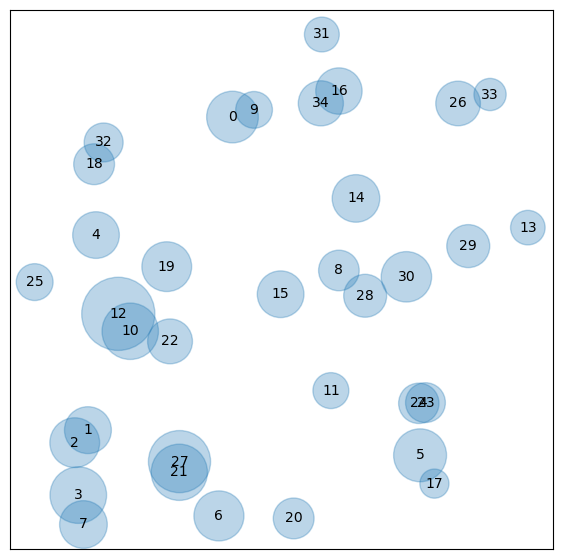

In [36]:
plot_topics(mdl)

## Interpret the model

What terms are associated with each topic? = $p(w|z)$

In [37]:
for k in range(mdl.k):
    print(f"{k:3d} ", ", ".join(s for s, _ in mdl.get_topic_words(k)))

  0  made, always, make, feel, every, front_desk, home, who, way, time
  1  lobby, elevator, door, down, street, elevators, into, right, open, walk
  2  noise, hear, sleep, loud, noisy, street, people, heard, morning, am
  3  shower, bed, tv, water, towels, desk, off, hot, floor, too
  4  4, 3, 5, 1, money, price, nights, pay, better, star
  5  away, street, walk, within, restaurants, across, blocks, walking_distance, right, boston
  6  check, arrived, ready, before, early, minutes, p.m., 3, checked, until
  7  dirty, bed, old, carpet, smell, floor, worst, ever, sheets, off
  8  view, chicago, large, floor, city, bed, quiet, check-in, quite, lobby
  9  husband, daughter, wedding, went, her, weekend, everything, made, trip, loved
 10  people, around, too, much, want, little, pretty, going, because, think
 11  area, motel, price, close, la, parking, inn, hollywood, downtown, right
 12  am, any, who, should, being, hotels, does, most, them, other
 13  suite, bedroom, kitchen, family, kids

Which documents best reflect each topic?

In [38]:
import textwrap


def print_topic_docs(topic, n_best=3):
    topic_weights = sorted(
        [(doc.get_topic_dist()[topic], i) for i, doc in enumerate(mdl.docs)],
        reverse=True,
    )
    for i in range(n_best):
        print(
            textwrap.indent(
                textwrap.fill(df["text"].iloc[topic_weights[i][1]], width=100), "  "
            )
        )
        print()

In [39]:
print_topic_docs(0)

  Matt the Bellman was outstanding. Traveling with my aunt and elderly mother. My mom was on oxygen
  and had a scooter. The bellman went beyond his call of duty to assist us. Made the trip so
  enjoyable. Was always greeted by the employees every day and evening.

  Henry Robinson is an outstanding employee!! His charm is always welcoming as you enter the hotel and
  always at your assistance when needed. Henry always greets you with a smile and asking if there is
  anything that he can do to make your stay more memorable..What an outstanding employee!!

  I would like to personally thank Krissy for her help, hospitality and constant smile during my
  extended stay at this hotel. This is my third extended stay here and she is always goes out of her
  way to ensure that my stay is one of the best possible. I travel frequently for my company and I
  request that I stay at the Hill Country Hotel & Spa when travelling to San Antonio. I look forward
  to returning to this fine facility as 

In [40]:
for topic in range(mdl.k):
    print(f"Topic = {topic} ({', '.join(s for s, _ in mdl.get_topic_words(topic))})")
    print()
    print_topic_docs(topic)
    print("--")

Topic = 0 (made, always, make, feel, every, front_desk, home, who, way, time)

  Matt the Bellman was outstanding. Traveling with my aunt and elderly mother. My mom was on oxygen
  and had a scooter. The bellman went beyond his call of duty to assist us. Made the trip so
  enjoyable. Was always greeted by the employees every day and evening.

  Henry Robinson is an outstanding employee!! His charm is always welcoming as you enter the hotel and
  always at your assistance when needed. Henry always greets you with a smile and asking if there is
  anything that he can do to make your stay more memorable..What an outstanding employee!!

  I would like to personally thank Krissy for her help, hospitality and constant smile during my
  extended stay at this hotel. This is my third extended stay here and she is always goes out of her
  way to ensure that my stay is one of the best possible. I travel frequently for my company and I
  request that I stay at the Hill Country Hotel & Spa when tra

### Happy with what you've got? Then save the final, best model

In [41]:
mdl.save("hotel-topics.bin")

In [42]:
topic_words = [[x for x, _ in mdl.get_topic_words(i)] for i in range(mdl.k)]
topics = pd.DataFrame(
    {
        "label": [x[0].upper() for x in topic_words],
        "words": [", ".join(x) for x in topic_words],
    }
)
topics.to_csv("labels.csv", index=False)

In [43]:
topics

,label,words
0,MADE,"made, always, make, feel, every, front_desk, h..."
1,LOBBY,"lobby, elevator, door, down, street, elevators..."
2,NOISE,"noise, hear, sleep, loud, noisy, street, peopl..."
3,SHOWER,"shower, bed, tv, water, towels, desk, off, hot..."
4,4,"4, 3, 5, 1, money, price, nights, pay, better,..."
5,AWAY,"away, street, walk, within, restaurants, acros..."
6,CHECK,"check, arrived, ready, before, early, minutes,..."
7,DIRTY,"dirty, bed, old, carpet, smell, floor, worst, ..."
8,VIEW,"view, chicago, large, floor, city, bed, quiet,..."
9,HUSBAND,"husband, daughter, wedding, went, her, weekend..."
